In [10]:
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Importing data preprocessing libraries
from sklearn.preprocessing import StandardScaler

# Importing model selection libraries.
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Importing metrics for model evaluation.
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# for knn
from sklearn.neighbors import KNeighborsClassifier

# Importing SMOTE for handling class imbalance.
from imblearn.over_sampling import SMOTE


### Importing the data

In [11]:
df = pd.read_csv('./data_cardiovascular_risk.csv', index_col='id')
df.head()


,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [12]:
df.shape

(3390, 16)

In [13]:
df.isna().sum()

,0
age,0
education,87
sex,0
is_smoking,0
cigsPerDay,22
BPMeds,44
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,38


### Data Cleaning

In [14]:
nan_columns = ["education", "cigsPerDay", "BPMeds", "totChol", "BMI", "heartRate"]

df.dropna(subset=nan_columns, inplace=True)


In [15]:
df.isna().sum()

,0
age,0
education,0
sex,0
is_smoking,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,0


In [16]:
df['glucose'] = df['glucose'].fillna(df['glucose'].median())
df['sex'] = df['sex'].map({"M": 1, "F": 0})
df['is_smoking'] = df['is_smoking'].map({"YES": 1, "NO": 0})
df['pulse_pressure'] = df['sysBP'] - df['diaBP']
df.drop(columns=['sysBP', 'diaBP'], inplace=True)

df.head(3)


,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose,TenYearCHD,pulse_pressure
id,,,,,,,,,,,,,,,
1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,29.77,72.0,75.0,0,70.0
2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,20.35,88.0,94.0,0,45.0
3,50,1.0,1,1,20.0,0.0,0,1,0,233.0,28.26,68.0,94.0,1,70.0


<Axes: >

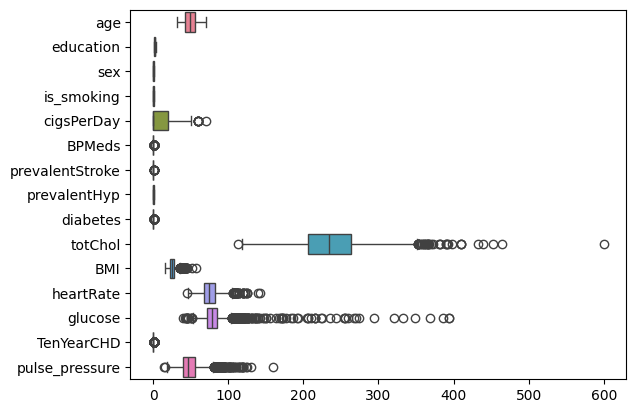

In [17]:
sns.boxplot(df, orient='h')

#### Visually it seems like there is some outliers in totChol, glucose and pulse_pressure.

#### Using Modified-Z score to tackle the problem

(3189, 15) --> (3176, 15)
(3176, 15) --> (3058, 15)
(3058, 15) --> (3000, 15)
(3000, 15) --> (2985, 15)


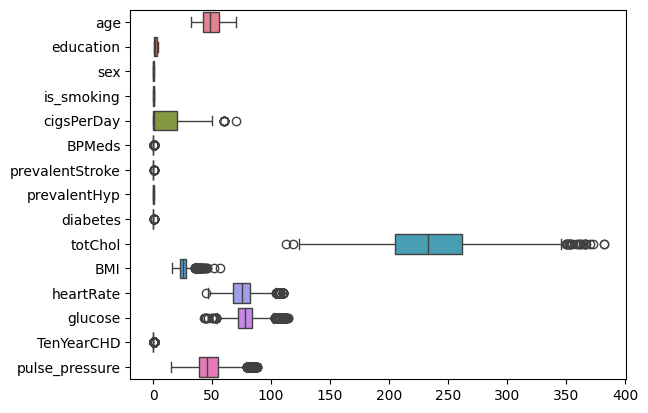

In [18]:
thresh = 3.5

# func to calcualte the modified z-score
def modified_z_score(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))

    return stats.norm.ppf(0.75) * (series - median) / mad


# iterate over all the columns and apply the modified z score function
cols_to_iterate = ['totChol', 'glucose', 'pulse_pressure', 'heartRate']

for col in cols_to_iterate:
    m_z_s = modified_z_score(df[col])
    print(df.shape, end=' --> ')
    df = df[m_z_s.abs() <= thresh]
    print(df.shape)

sns.boxplot(df, orient='h');


In [19]:
df.head(2)

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,BMI,heartRate,glucose,TenYearCHD,pulse_pressure
id,,,,,,,,,,,,,,,
1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,29.77,72.0,75.0,0,70.0
2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,20.35,88.0,94.0,0,45.0


In [20]:
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

X.shape, y.shape


((2985, 14), (2985,))

### Handling Data Imbalance with SMOTE

Text(0.5, 1.0, 'Data Imbalance')

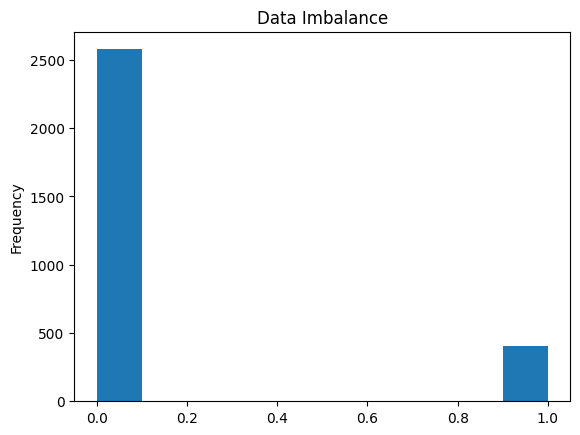

In [21]:
df['TenYearCHD'].plot(kind='hist')
plt.title('Data Imbalance')


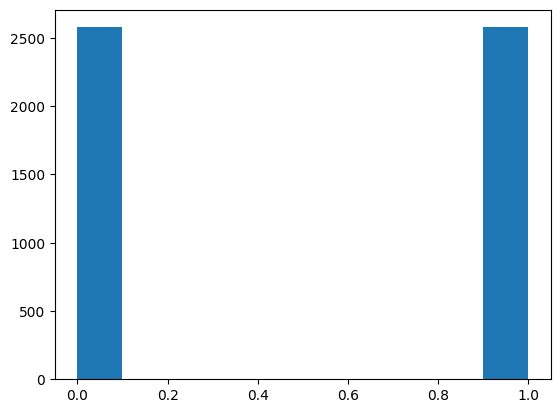

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

y.value_counts()

# df['TenYearCHD'].plot(kind='hist')
plt.hist(y)
plt.show()

### Split the data for training and testing

In [23]:
from sklearn.preprocessing import StandardScaler
import joblib


scaler = StandardScaler()
scaler.fit(X)

# save the scaler
joblib.dump(scaler, 'scaler.joblib')


X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4124, 14), (1032, 14), (4124,), (1032,))

### Finding the best parameters for KNN.

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


clf = GridSearchCV(KNeighborsClassifier(), {
    'n_neighbors': [*range(1, 20, 4)],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}, cv=5, return_train_score=False)

# model = KNeighborsClassifier()
# model.fit(X_train, y_train)


In [25]:
clf.fit(X_train, y_train)
results = pd.DataFrame(clf.cv_results_)
results[['param_algorithm','param_n_neighbors', 'param_weights', 'mean_test_score']].sort_values(by=['mean_test_score'],ascending=False)


,param_algorithm,param_n_neighbors,param_weights,mean_test_score
0,auto,1,uniform,0.814261
10,ball_tree,1,uniform,0.814261
31,brute,1,distance,0.814261
30,brute,1,uniform,0.814261
21,kd_tree,1,distance,0.814261
1,auto,1,distance,0.814261
11,ball_tree,1,distance,0.814261
20,kd_tree,1,uniform,0.814261
33,brute,5,distance,0.780067
13,ball_tree,5,distance,0.780067


In [26]:
clf.best_score_

0.8142612533097969

In [27]:
clf.best_params_

{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}

In [28]:
# dir(clf)
model = clf.best_estimator_

In [29]:
y_preds = model.predict(X_test)
model.score(X_test, y_test)

0.8333333333333334

In [30]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train, cv=5).mean()

0.8142612533097969

In [31]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.73      0.82       516
           1       0.78      0.93      0.85       516

    accuracy                           0.83      1032
   macro avg       0.85      0.83      0.83      1032
weighted avg       0.85      0.83      0.83      1032



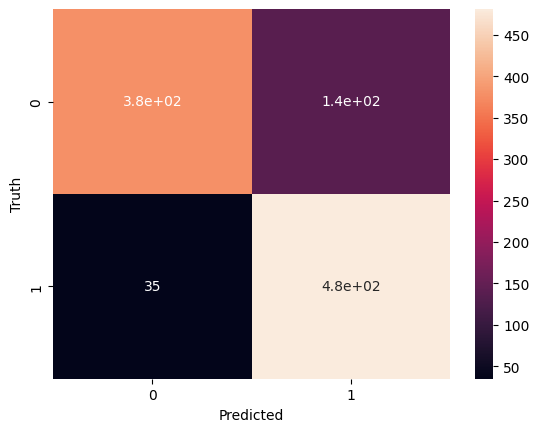

In [32]:
from seaborn import heatmap

cmap = confusion_matrix(y_test, y_preds)
heatmap(cmap, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [33]:
joblib.dump(model, "model_KNeighborsClassifier.joblib")


['model_KNeighborsClassifier.joblib']